In [4]:
import numpy as np

from IPython.display import display

import os
import sys
import importlib

sys.path.insert(0, "..")

import draughts
import board
import preprocessing
import engine

importlib.reload(draughts);
importlib.reload(board);
importlib.reload(preprocessing);
importlib.reload(engine);

In [5]:
my_board = draughts.Board()
my_board

. o . o . o . o
o . o . o . o .
. o . o . o . o
. . . . . . . .
. . . . . . . .
O . O . O . O .
. O . O . O . O
O . O . O . O .

In [8]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

tf.config.run_functions_eagerly(True)

In [9]:
def get_conv_net():
    model = keras.models.Sequential()
    model.add(layers.Conv2D(128, (2, 2), activation="relu", input_shape=(8, 8, 5)))
    # model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D())
    model.add(layers.Conv2D(128, (2, 2), activation="relu"))
    # model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D())
#     model.add(layers.Conv2D(128, (2, 2), activation="relu"))
    # model.add(layers.BatchNormalization())
#     model.add(layers.MaxPool2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2()))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(128, activation="sigmoid"))

#     sgd = keras.optimizers.SGD(learning_rate=0.01)

    model.compile(optimizer="adam", 
                  loss=keras.losses.MeanSquaredError(), 
                  metrics=["accuracy"])
    
    return model

In [10]:
white_model = get_conv_net()
black_model = get_conv_net()

In [11]:
white_model.load_weights("w_weights.h5")
black_model.load_weights("b_weights.h5")

In [12]:
num_dict = {l : i+1 for i, l in enumerate("abcdefgh")}

def cell_dist(cell1, cell2):
    p1 = np.array([num_dict[cell1[0]], int(cell1[1])])
    p2 = np.array([num_dict[cell2[0]], int(cell2[1])])
    return np.linalg.norm(p1 - p2)


def find_closest_move(move, valid_moves):
#     print(valid_moves)
#     print(move)
    distance = np.inf
    best_moves = []
    for m in valid_moves:
        if move == m:
            return move
        if m.empty:
            continue
        dist = cell_dist(move.from_pos, m.from_pos)
        if dist < distance:
            best_moves.append(m)
            distance = dist
            
    closest_move = None
    distance = np.inf
            
    for m in best_moves:
        dist = cell_dist(move.to_pos, m.to_pos)
        if dist < distance:
            closest_move = m
            distance = dist
            
    return closest_move

In [13]:
my_board = draughts.Board()

white_won = 0
black_won = 0
iter_count = 0

white_train_data = []
white_test_data = []

black_train_data = []
black_test_data = []

In [14]:
def cost_function(w, b):
    return abs(w - b)

In [15]:
def train():
    
    global my_board
    global white_won
    global black_won
    global iter_count
    global white_train_data
    global white_test_data 
    global black_train_data
    global black_test_data 
    
    white_wins = 0
    black_wins = 0
    
    def reset_won_status():
        white_wins = 0
        black_wins = 0
    
    for i in range(20000):
        iter_count += 1
#         if iter_count % 200 == 0:
#             white_model.save_weights("new_w_weights.h5")
#             black_model.save_weights("new_b_weights.h5")
        
        white_random_moves = 0
        black_random_moves = 0
        
        c_white_train_data = []
        c_white_test_data = []
        c_black_train_data = []
        c_black_test_data = []
        
        print("Game number -", iter_count)

        while my_board.engine.is_finished() == engine.GameState.INDETERMINATE or my_board.engine.is_draw():
            b_valid_moves = my_board.valid_moves()
                
            closest_move = None
            
            inp = preprocessing.board_layout_to_network_input(my_board.engine.layout)
            
            if my_board.engine.turn:
                if black_wins == 1 and np.random.randint(4) == 0:
                    closest_move = np.random.choice(b_valid_moves)
                    white_random_moves += 1
                else:
                    net_move = preprocessing.network_output_to_move(white_model.predict(np.array([inp]))[0])
                    closest_move = find_closest_move(net_move, b_valid_moves)
                        
            elif not my_board.engine.turn:
                if white_wins == 1 and np.random.randint(4) == 0:
                    closest_move = np.random.choice(b_valid_moves)
                    black_random_moves += 1
                else:
                    net_move = preprocessing.network_output_to_move(black_model.predict(np.array([inp]))[0])
                    closest_move = find_closest_move(net_move, b_valid_moves)
                        
#             if np.random.randint(4) != 0:
#                 if my_board.engine.turn:
#                     net_move = preprocessing.network_output_to_move(white_model.predict(np.array([inp]))[0])
#                     closest_move = find_closest_move(net_move, b_valid_moves)
#                 elif not my_board.engine.turn:
#                     net_move = preprocessing.network_output_to_move(black_model.predict(np.array([inp]))[0])
#                     closest_move = find_closest_move(net_move, b_valid_moves)
                
            move_out = preprocessing.move_to_network_output(closest_move)

            if my_board.engine.turn:
                c_white_train_data.append(inp)
                c_white_test_data.append(move_out)
            elif not my_board.engine.turn:
                c_black_train_data.append(inp)
                c_black_test_data.append(move_out)
                
            my_board.push_move(closest_move)
            
        if not c_white_train_data or not c_white_test_data:
            print("PANIC ERROR WHITE")
        
        if not c_black_train_data or not c_black_test_data:
            print("PANIC ERROR BLACK")

        if my_board.engine.is_finished() == engine.GameState.WHITE_WON:
            print("White won")
#             cboard = draughts.Board()
#             cboard.engine.layout = preprocessing.network_input_to_board_layout(white_train_data[1])
#             display(cboard.show())
#             print(preprocessing.network_output_to_move(white_test_data[1]))
            white_won += 1
            white_wins = 1
            black_wins = 0
            if white_random_moves != 0:
                print("White Update...")
                reset_won_status()
                white_train_data.extend(c_white_train_data)
                white_test_data.extend(c_white_test_data)
                white_model.fit(np.array(c_white_train_data), np.array(c_white_test_data), epochs=20, batch_size=32, verbose=0)
        if my_board.engine.is_finished() == engine.GameState.BLACK_WON:
            print("Black won")
#             cboard = draughts.Board()
#             cboard.engine.layout = preprocessing.network_input_to_board_layout(black_train_data[1])
#             display(cboard.show())
#             print(preprocessing.network_output_to_move(black_test_data[1]))
            black_won += 1
            black_wins = 1
            white_wins = 0
            if black_random_moves != 0:
                print("Black Update...")
                reset_won_status()
                black_train_data.extend(c_black_train_data)
                black_test_data.extend(c_black_test_data)
                black_model.fit(np.array(c_black_train_data), np.array(c_black_test_data), epochs=20, batch_size=32, verbose=0)

        print("White random moves -", white_random_moves)
        print("Black random moves -", black_random_moves)
        print("Board evalutation -", my_board.engine.evaluate())
        print("Win status ~", "WHITE" if white_wins == 1 else "BLACK")
        print("Game difference ~", cost_function(white_won, black_won))
        print()
        my_board.engine.reset()

In [ ]:
# def train_function():
#     try:
#         # train_function()
# if iter_count != 20000:
#             train()
#     except:
#         train_function()

train()

Game number - 13878
Black won
White random moves - 0
Black random moves - 0
Board evalutation - -6
Win status ~ BLACK
Game difference ~ 476

Game number - 13879
White won
White Update...
White random moves - 9
Black random moves - 0
Board evalutation - 3
Win status ~ WHITE
Game difference ~ 475

Game number - 13880
White won
White random moves - 0
Black random moves - 5
Board evalutation - 6
Win status ~ WHITE
Game difference ~ 474

Game number - 13881
White won
White random moves - 0
Black random moves - 6
Board evalutation - 13
Win status ~ WHITE
Game difference ~ 473

Game number - 13882
Black won
Black Update...
White random moves - 0
Black random moves - 5
Board evalutation - -9
Win status ~ BLACK
Game difference ~ 474

Game number - 13883
White won
White Update...
White random moves - 11
Black random moves - 0
Board evalutation - 6
Win status ~ WHITE
Game difference ~ 473

Game number - 13884
Black won
Black Update...
White random moves - 0
Black random moves - 8
Board evalutatio

White won
White random moves - 0
Black random moves - 8
Board evalutation - 9
Win status ~ WHITE
Game difference ~ 475

Game number - 13934
White won
White random moves - 0
Black random moves - 6
Board evalutation - 7
Win status ~ WHITE
Game difference ~ 474

Game number - 13935
White won
White random moves - 0
Black random moves - 9
Board evalutation - 13
Win status ~ WHITE
Game difference ~ 473

Game number - 13936
White won
White random moves - 0
Black random moves - 3
Board evalutation - 6
Win status ~ WHITE
Game difference ~ 472

Game number - 13937
Black won
Black Update...
White random moves - 0
Black random moves - 4
Board evalutation - -6
Win status ~ BLACK
Game difference ~ 473

Game number - 13938
Black won
White random moves - 8
Black random moves - 0
Board evalutation - -11
Win status ~ BLACK
Game difference ~ 474

Game number - 13939
Black won
White random moves - 7
Black random moves - 0
Board evalutation - -7
Win status ~ BLACK
Game difference ~ 475

Game number - 13940

Black won
Black Update...
White random moves - 0
Black random moves - 7
Board evalutation - -5
Win status ~ BLACK
Game difference ~ 477

Game number - 13990
Black won
White random moves - 6
Black random moves - 0
Board evalutation - -3
Win status ~ BLACK
Game difference ~ 478

Game number - 13991
White won
White Update...
White random moves - 5
Black random moves - 0
Board evalutation - 9
Win status ~ WHITE
Game difference ~ 477

Game number - 13992
Black won
Black Update...
White random moves - 0
Black random moves - 7
Board evalutation - -5
Win status ~ BLACK
Game difference ~ 478

Game number - 13993
White won
White Update...
White random moves - 3
Black random moves - 0
Board evalutation - 6
Win status ~ WHITE
Game difference ~ 477

Game number - 13994
Black won
Black Update...
White random moves - 0
Black random moves - 6
Board evalutation - -8
Win status ~ BLACK
Game difference ~ 478

Game number - 13995
Black won
White random moves - 5
Black random moves - 0
Board evalutation - 

White won
White Update...
White random moves - 12
Black random moves - 0
Board evalutation - 4
Win status ~ WHITE
Game difference ~ 489

Game number - 14046
White won
White random moves - 0
Black random moves - 9
Board evalutation - 10
Win status ~ WHITE
Game difference ~ 488

Game number - 14047
Black won
Black Update...
White random moves - 0
Black random moves - 11
Board evalutation - -5
Win status ~ BLACK
Game difference ~ 489

Game number - 14048
Black won
White random moves - 9
Black random moves - 0
Board evalutation - -3
Win status ~ BLACK
Game difference ~ 490

Game number - 14049
White won
White Update...
White random moves - 8
Black random moves - 0
Board evalutation - 8
Win status ~ WHITE
Game difference ~ 489

Game number - 14050
White won
White random moves - 0
Black random moves - 9
Board evalutation - 8
Win status ~ WHITE
Game difference ~ 488

Game number - 14051
Black won
Black Update...
White random moves - 0
Black random moves - 7
Board evalutation - -6
Win status ~

In [17]:
rand_int = np.random.randint(len(black_test_data))

test_board = draughts.Board()
test_board.engine.layout = preprocessing.network_input_to_board_layout(white_train_data[rand_int])
test_move = preprocessing.network_output_to_move(white_test_data[rand_int])
test_move

Move( d4f6 )

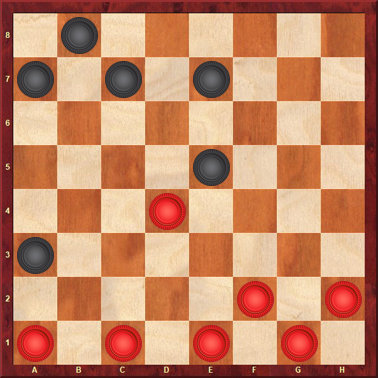

In [18]:
test_board.show()

In [191]:
iter_count

4649

In [20]:
white_model.save_weights("w_weights.h5")
black_model.save_weights("b_weights.h5")

In [193]:
my_board.engine.reset()

In [40]:
white_won, black_won

(6700, 7175)

In [21]:
my_board.engine._fig_count

{'O': 7, 'o': 1, 'X': 0, 'x': 0, '.': 56}

In [22]:
my_board.engine.is_finished()

<GameState.INDETERMINATE: 3>

In [23]:
new_board = draughts.Board()

def play(move):
#     new_board.push(move)
    output_vec = black_model.predict(np.array([preprocessing.board_layout_to_network_input(new_board.engine.layout)]))
#     print(output_vec)
    net_move = preprocessing.network_output_to_move(output_vec[0])
    closest_move = find_closest_move(net_move, new_board.valid_moves())
    print("Network move", net_move)
    print(closest_move)
    new_board.push_move(closest_move)
    display(new_board.show())

Network move Move( d8c7 )
Move( d8c7 )


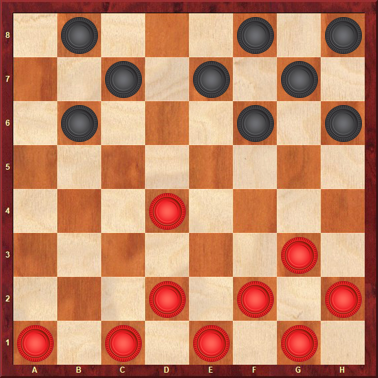

In [38]:
# new_board.push("g5f4")
play("e6e5")

In [263]:
new_board.valid_moves()

(Move( c3a5 ),)